In [1]:
! pip install langgraph 


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install langchain_community


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install langchain_huggingface


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
! pip install Chromadb


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
! pip install tavily


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
! pip install langchain


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated,Literal,Tuple,Optional
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
import requests
import os
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings



d:\Desktop\Agentic-Rag-Chatbot\envv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
load_dotenv()

True

In [9]:
class Agentstate(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]
    context:str
    


In [10]:
! pip install sentence-transformers


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
! pip install openai


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np


from langchain.tools import tool
from langchain_community.utilities import WikipediaAPIWrapper

@tool
def wikipedia_search(query: str) -> str:
    """Searches Wikipedia for a given topic and returns a short summary.
    
    Use this when the user asks about factual, historical, or conceptual information.
    """
    try:
        wiki = WikipediaAPIWrapper()
        result = wiki.run(query)
        if result:
            return result
        else:
            return f"No relevant Wikipedia content found for '{query}'."
    except Exception as e:
        return f"Error fetching Wikipedia data: {str(e)}"
    
#bmi api
@tool
def calculate_bmi(height:float,weight:float)->Tuple[float,str]:
    """
    Calculate the Body Mass Index (BMI) based on a person's height (in meters) and weight (in kilograms).
    Use this tool when a user asks about BMI, health category, or body weight status."""
    bmi=weight/(height**2)
    if bmi < 18.5:
        category = "Underweight"
    elif 18.5 <= bmi < 25:
        category = "Normal weight"
    elif 25 <= bmi < 30:
        category = "Overweight"
    else:
        category = "Obese"
    
    return bmi, category

search_tool=DuckDuckGoSearchRun(region="us-en")

@tool
def get_weather_update(symbol:str):
    """
    Fetch the current weather information for a specific city using the OpenWeather API.
    Use this tool when a user asks about the weather, temperature, or weather conditions in any location."""
    api_key=os.getenv("WEATHER_API_KEY")
    url=f"http://api.openweathermap.org/data/2.5/weather?q={symbol}&appid={api_key}&units=metric"
    try:
        response=requests.get(url)
        return response.json()
    except requests.exceptions.RequestException as e:
        return {"error":str(e)}
    

@tool
def get_conversion_factor(base_currency:str,target_currency:str,amount:str)->float:
    """
    Convert a specific amount from one currency to another using real-time exchange rates.
    Use this tool when a user asks to convert money between different currencies. """
    api_key=os.getenv("CURRENCY_CONVERSION_API_KEY")
    url=f"https://api.exchangerate.host/convert?from={base_currency}&to={target_currency}&amount={amount}&access_key={api_key}"
    response=requests.get(url)
    return response.json()


@tool
def get_stock(symbol:str)->str:
    """ Retrieve the latest intraday stock price and related information for a given company ticker symbol.
    Use this tool when a user asks for stock prices, share values, or stock market updates. """
    api_key=os.getenv("STOCK_API_KEY")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&apikey={api_key}"
    response = requests.get(url)
    return response.json()
    

@tool
def calculator(a:int,b:int,operation:str)->float:
    """ Perform basic arithmetic operations such as addition, subtraction, multiplication, division, power, and square root.
    Use this tool when a user asks to perform a mathematical calculation."""
    if operation=="add":
        return a+b
    elif operation=="subtract":
        return a-b
    elif operation=="product":
        return a*b
    elif operation=="divide":
        return a/b
    elif operation=="power":
        return a**b
    elif operation=="sqrt":
        return np.sqrt(a)


In [13]:
llm1=HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.7,task="text-generation",model_kwargs={"api_key":"HUGGINGFACEHUB_API_TOKEN"})
model=ChatHuggingFace(llm=llm1)

In [14]:
tools=[calculate_bmi,search_tool,get_weather_update,get_conversion_factor,get_stock,calculator,wikipedia_search]

In [15]:
llm_with_tool=model.bind_tools(tools)

In [16]:
Ai_message=llm_with_tool.invoke("What is Weather in Gurugram?")
Ai_message

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"symbol":"Gurugram"}', 'name': 'get_weather_update', 'description': None}, 'id': 'fc_3d484fcf-4b02-4cf2-94de-b5692e9fff37', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 477, 'total_tokens': 527}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d50e63726', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--e6230174-ce8c-400e-aa5f-eb039adde7d9-0', tool_calls=[{'name': 'get_weather_update', 'args': {'symbol': 'Gurugram'}, 'id': 'fc_3d484fcf-4b02-4cf2-94de-b5692e9fff37', 'type': 'tool_call'}], usage_metadata={'input_tokens': 477, 'output_tokens': 50, 'total_tokens': 527})

In [17]:
! pip install google-api-python-client

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from googleapiclient.discovery import build

d:\Desktop\Agentic-Rag-Chatbot\envv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [19]:
! pip install bs4


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from langchain_core.messages import ToolMessage

In [21]:

#Define node function
def chat_model(state: Agentstate):
    latest_msg = state["messages"][-1].content.lower()
    if any(word in latest_msg for word in ["explain", "describe","What is","information"]):
        # RAG will handle, don't generate yet
        return {"messages": state["messages"]}
    elif any(word in latest_msg for word in ["stock", "calculate", "weather", "news", "bmi", "conversion", "currency"]):
        # Tool will handle, don't generate yet
        response = llm_with_tool.invoke(latest_msg)
        state["tool_invoked"] = True  # Set the flag to True
        return {"messages": state["messages"] + [response]}
    else:
        # LLM can answer directly
        response = llm_with_tool.invoke(state["messages"])
        return {"messages": state["messages"] + [response]}



# Wrap the ToolNode in a callable function for your workflow
tool_node_instance = ToolNode(tools)

def generate_tool_response(state: Agentstate):
    # find the latest ToolMessage content

    tool_messages = [m for m in state["messages"] if isinstance(m, ToolMessage)]
    if not tool_messages:
        return {"messages": [AIMessage(content="No tool output found.")]}

    latest_tool_output = tool_messages[-1].content

    # Now use your llm to produce final answer
    response = llm_with_tool.invoke([
        HumanMessage(content=f"Give one line response to this tool result: {latest_tool_output}")
    ])
    return {"messages": [response]}

    
def rag_node(state: Agentstate):
    query=state["messages"][-1].content.strip()
    limit=3
    google_api_key = os.getenv("GOOGLE_API_KEY")
    cse_id = os.getenv("GOOGLE_CSE_ID") 
    if not google_api_key or not cse_id:
        raise RuntimeError("Please set Google APi Key in your environment.")
    
    try:
        service = build("customsearch", "v1", developerKey=google_api_key)
        response = service.cse().list(q=query,cx=cse_id,num=limit).execute()
        urls = [item.get("link") for item in response.get("items", [])][:limit]
    except Exception as e:
        print("Error retrieving URLs:", e)
        urls = []

    if not urls:
        return {"context": "No relevant information found.", "messages": state["messages"]}

    
    #Document loader  
    docs=[]
    for url in urls:
        loader=WebBaseLoader(url)
        docs.extend(loader.load())
        
    #Text-splitter
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200)
    
    chunks=text_splitter.split_documents(docs)
    
    #embedding
    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    
    #vector_store
    vector_store=Chroma.from_documents(
        embedding=embedding,
        documents=chunks,
        collection_name="my_data"
    )
    retriver=vector_store.as_retriever(search_kwargs={"k":3},search_type="similarity")
    retrieved_docs=retriver.invoke(query)
    
    def format_docs(docs):
        return "\n".join(doc.page_content for doc in docs)
    
    context=format_docs(retrieved_docs)
    
    return {"context":context}

def generate_rag(state:Agentstate):
    query=state["messages"][-1].content
    context=state["context"]
    prompt=PromptTemplate(template=""" You are a Powerful assistant, Generate the final answer from the context {context} and provided question:{question} """,input_variables=["context","question"])
    model=llm_with_tool
    parser=StrOutputParser()
    
    chain=prompt|model|parser
    
    response=chain.invoke({"context":context,"question":query})
    
    return {"messages":[AIMessage(content=response)]}


def check_condition(state:Agentstate):
    latest_message = next(
        (m.content.lower() for m in reversed(state["messages"]) if isinstance(m, HumanMessage)),
        ""
    )
    rag_keywords = [
        "explain", "describe", "define", "tell me about", 
        "information", "details on", "who is", "history of", "when was", "why does"
    ]
    tool_keywords = [
        # BMI or calculation-related
        "bmi", "body mass", "calculate", "compute", "math", "sum", "add", "subtract", "divide", "multiply", "square root",
        # Currency or conversion
        "convert", "exchange rate", "currency", "usd", "inr", "euro", "dollar", 
        # Stocks
        "stock", "share", "price", "market", "equity",
        # Weather
        "weather", "temperature", "forecast", "climate",
        # AI news
        "news", "ai update", "ai news", "latest ai", "tech news", "technology"
    ]


    if any(kw in latest_message for kw in rag_keywords):
        print("Routing to RAG")
        return "rag_node"
    elif any(kw in latest_message for kw in tool_keywords):
        print("Routing to TOOL")
        return "tool_node"
    else:
        print("Routing to CHAT")
        return "END"
        
     

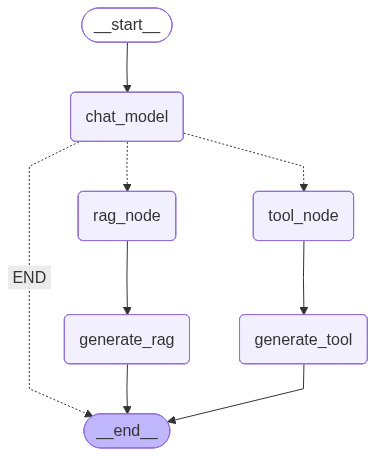

In [22]:
graph = StateGraph(Agentstate)
checkpointer=InMemorySaver()
graph.add_node("chat_model", chat_model)
graph.add_node("rag_node", rag_node)
graph.add_node("tool_node", tool_node_instance)
graph.add_node("generate_rag", generate_rag)
graph.add_node("generate_tool",generate_tool_response)

graph.add_edge(START, "chat_model")

graph.add_conditional_edges(
    "chat_model",
    check_condition,
    {
        "rag_node": "rag_node",
        "tool_node": "tool_node",
        "END": END,
    }
)

graph.add_edge("rag_node", "generate_rag")
graph.add_edge("tool_node", "generate_tool")
graph.add_edge("generate_rag", END)
graph.add_edge("chat_model",END)
graph.add_edge("generate_tool",END)

workflow = graph.compile(checkpointer=checkpointer)
workflow



In [23]:
thread_id="1"
initial_state={"messages":[HumanMessage(content="Describe Red fort attack in Delhi")]}
config={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config)
output["messages"]
output["messages"][-1].content


Routing to RAG


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


'**Red Fort Attack – Delhi (22\u202fDecember\u202f2000)**  \n\n- **Date & Time:** 22\u202fDecember\u202f2000, early morning.  \n- **Location:** Red Fort (Lal Qila), the historic Mughal citadel in central Delhi.  \n- **Perpetrators:** Six operatives belonging to the militant group **Lashkar‑e‑Taiba** (Lt‑B).  \n- **Motivation / Context:** The attack was timed to coincide with the end of the **India‑Pakistan peace talks** that had been underway in the preceding weeks, in an attempt to destabilise the diplomatic process and create chaos on a symbolic site of national heritage.  \n- **Course of the Attack:**  \n  - The attackers entered the fort complex through a gate and moved toward the main courtyard.  \n  - They opened fire on guards and civilians present at the fort.  \n  - The assault was brief, lasting only a few minutes before the attackers were intercepted by Indian security forces.  \n- **Casualties:**  \n  - **2 Indian Army soldiers** were killed.  \n  - **1 civilian** (a visito

In [24]:
thread_id="3"
initial_state={"messages":[HumanMessage(content="Write a poem on pizza")]}
config={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config)
output["messages"][-1].content

Routing to CHAT


'**Ode to the Slice**\n\nIn a kitchen where aromas curl like a warm secret,  \na circle of dough takes its first breath,  \nswayed by a hand that knows no rush.  \n\nTomato—red, bright as sunrise—spreads,  \na velvet river that swallows the crust’s edge,  \nwhile garlic whispers from the shadows,  \nand oregano sighs like an old lullaby.\n\nMozzarella drifts, pale and soft,  \nclouds of cream that melt with a sigh,  \neach bite a gentle, fragrant tide,  \na hug of gooey, golden bliss.\n\nBasil leaves unfurl in green ribbons,  \ntheir fragrance a promise of summer,  \nwhile pepperoni curls, a fiery dance,  \nspicing the air with a playful spark.\n\nThe oven, a furnace of promise,  \nturns the humble circle into a glowing orb;  \nthe crust cracks with a satisfying sigh,  \na crisp whisper of satisfaction.\n\nSliced, the pie sings a chorus of textures:  \nthe crunch of the edge, the velvet melt,  \nthe bite that echoes laughter in a circle of friends.\n\nOh pizza, simple and profound,  \n

In [25]:
thread_id="2"
initial_state={"messages":[HumanMessage(content="What is weather of Gurugram")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


'In Gurugram, it’s 25\u202f°C with hazy skies, 1.8\u202fkm visibility, and light winds coming from the west.'

In [26]:
thread_id="2"
initial_state={"messages":[HumanMessage(content="What is stock price of Apple Company")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Routing to TOOL


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


'As of\u202f2025‑11‑17\u202f19:55:00, Apple (AAPL) closed at\u202f$267.69 on the 5‑minute chart, trading\u202f2,903\u202fshares.'

In [32]:
thread_id="4"
initial_state={"messages":[HumanMessage(content="add 123 and 234")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"]

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[HumanMessage(content='add 123 and 234', additional_kwargs={}, response_metadata={}, id='fa47e708-b465-4816-bdf7-541c0a098a05'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"a":123,"b":234,"operation":"add"}', 'name': 'calculator', 'description': None}, 'id': 'fc_6949c6e1-58f6-4da4-aaf9-d0df3407eaa9', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 475, 'total_tokens': 526}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d50e63726', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a6a74927-15c2-41f8-b58f-351535ae9127-0', tool_calls=[{'name': 'calculator', 'args': {'a': 123, 'b': 234, 'operation': 'add'}, 'id': 'fc_6949c6e1-58f6-4da4-aaf9-d0df3407eaa9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 475, 'output_tokens': 51, 'total_tokens': 526}),
 ToolMessage(content='357', name='calculator', id='4885104a-2f9a-4bbc-968c-ab399dad9ba0', tool_call_id='fc_6949c

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [28]:
thread_id="5"
initial_state={"messages":[HumanMessage(content="What is current Ai News")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"]


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[HumanMessage(content='What is current Ai News', additional_kwargs={}, response_metadata={}, id='996f1c14-2a48-4f29-9de4-b7b14060152a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"current AI news"}', 'name': 'duckduckgo_search', 'description': None}, 'id': 'fc_114d3c58-35e9-4b3d-a683-73a8c143818b', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 474, 'total_tokens': 542}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_34cb00738d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--bf019168-0d27-4724-b1ce-7523cadb9e95-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current AI news'}, 'id': 'fc_114d3c58-35e9-4b3d-a683-73a8c143818b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 474, 'output_tokens': 68, 'total_tokens': 542}),
 ToolMessage(content='Eligibility requires at least one Eligible Payroll Deposit of $200 or more into your Cur

In [29]:
thread_id="6"
initial_state={"messages":[HumanMessage(content="Calculate the  BMI of height 19.2 and weight 50")]}
config2={"configurable":{"thread_id":thread_id}}
output=workflow.invoke(initial_state,config=config2)
output["messages"][-1].content

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Routing to TOOL


'Your BMI is 13.6, which places you in the underweight category.'

In [30]:
list[workflow.get_state(config=config2)]

list[{'messages': [HumanMessage(content='Calculate the  BMI of height 19.2 and weight 50', additional_kwargs={}, response_metadata={}, id='821854ac-e935-433d-844c-a9f0d3e2c85e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"height":1.92,"weight":50}', 'name': 'calculate_bmi', 'description': None}, 'id': 'fc_6790ae8b-90fe-4e68-9e89-dfba08db8d78', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 483, 'total_tokens': 625}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_34cb00738d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--1416b5a5-ad7e-41ce-b5a4-d06ae6457477-0', tool_calls=[{'name': 'calculate_bmi', 'args': {'height': 1.92, 'weight': 50}, 'id': 'fc_6790ae8b-90fe-4e68-9e89-dfba08db8d78', 'type': 'tool_call'}], usage_metadata={'input_tokens': 483, 'output_tokens': 142, 'total_tokens': 625}), ToolMessage(content='[13.563368055555555, "Underweight"]', name='calculat

In [31]:
# workflow.get_state_history(config=config)

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
